# 串起来：让机器人可以简单地玩游戏


In [1]:
from CyClient import *
import time
import numpy as np
from matchUtil import *
from Cut import *
import matplotlib.pyplot as plt
from findTemplate import *
cli = Client()
cli.sayHello()

received:     Hello From Server 


In [2]:
cli.takAction(4,0,0)
time.sleep(0.5)
cli.takAction(3,0,0)

received:     M         4         0         0
received:     M         3         0         0


## test

received: 
600 800 3
30000


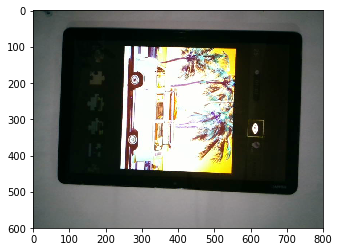

2.04541015625


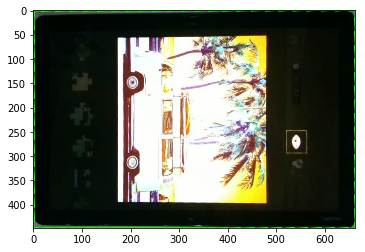

In [6]:
test = cli.getPic()
plt.imshow(test)
plt.show()
cut = get_Contour(test)
plt.imshow(cut)
plt.show()

In [4]:
from matchUtil import *

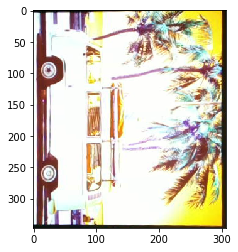

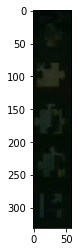

[25, 140]


In [7]:
sor = cutout_source(cut,cut)
plt.imshow(sor)
plt.show()  
#s_x = int(sor.shape[0]/5)
#s_y = int(sor.shape[1]/5)
    
temp_area = cutout_template_area(cut,cut)
plt.imshow(temp_area)
plt.show()
temp_pos = []
temp = cutout_template(cut,cut,temp_pos)
#temp_pos
plt.imshow(temp)
print(temp_pos)

In [70]:
img = ply.getOneShot()
plt.imsave("fullEmpty.png",img)

received: 
600 800 3
30000
-0.0


In [18]:
template = cut
print(temp_pos)
imgshape = template.shape
print(imgshape)
#PHONESIZE = (155,235)
diviceShape = (155,235)
temp_pos_1 = (temp_pos[0]+20 + template.shape[1]*0.114 , temp_pos[1] +25+ template.shape[0]*0.111)
print(temp_pos_1)
x,y =temp_pos_1
#1,0,0,1
x =  (1-x/imgshape[1]) * diviceShape[1] # because x is converted
y =  y/imgshape[0] * diviceShape[0]
print(x+10,y+10)

[6, 10]
(505, 735, 3)
(109.79, 91.055)
209.89707482993197 37.94757425742574


In [58]:
x,y = temp_pos_1
(1-x/imgshape[1])*

0.8352455418381344

In [14]:
cli.takAction(1,int(x),int(y))

received:     M         1         1 2 5         1 3 7


In [52]:
cli.takAction(1,110,210)

received:     M         1         1 1 0         2 1 0


received: 
600 800 3
30000
-0.0


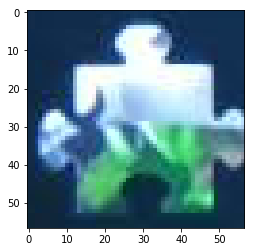

In [86]:
def BGR_RGB(img):
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return new_img

test = cli.getPic()
#plt.imshow(test)
# cv2.imwrite("原始图.png",test)
cut = get_Contour(test)
cut = BGR_RGB(cut)
# plt.imshow(BGR_RGB( test))
# plt.show()
# plt.imsave("原始图.png",BGR_RGB( test))
# plt.imsave("截了平板的.png",BGR_RGB(cut))
#cv2.imwrite("cut_pad.png",cut)
# plt.imshow(BGR_RGB( cut))
# plt.show()
# sor = cutout_target(cut)
# sor = BGR_RGB(sor)
# plt.imsave("中心原图.png",sor)
# plt.imshow(sor)
# plt.show()

# plt.imsave("pic3.png",cut)
temp_area = cutout_template_area(cut,cut)
plt.imshow(temp_area)
plt.imsave("template_area.png",temp_area)
temp_pos = []
temp = cutout_template(cut,cut,temp_pos)
#temp_pos
plt.imshow(temp)
plt.show()
plt.imsave("a_template.png",temp)

# calibration

In [69]:
cli.takAction(1,10,10)

received:     M         1         1 0         1 0


In [70]:
cli.takAction(1,170,10)

received:     M         1         1 7 0         1 0


In [68]:
cli.takAction(1,10,255)

received:     M         1         1 0         2 5 5


In [22]:
cli.getPos() # left upper corner  it is 85, 10, 0, right bottom corner is 15 -135 
'''
base
base = 10 10
pad:left upper corner is 165,10 ,right bottom corner is 15,245,
'''


received: 
(10.0, 245.0, 0)


'\nbase\nbase = 10 10\npad:left upper corner is 165,10 ,right bottom corner is 15,245,\n'

In [8]:
# PHONESIZE = (150,235)
PHONESIZE = (160,245)


In [9]:
class Player:
    def __init__(self,cli):
        self.cli = cli
        self.basePoint = np.array([0,0])
        self.sourceimg = None # the image of the jagsaw to recover
        self.emptyimg = None # the image of the empty target area 
    def setBase(self):
        # move to where 0,0 point should be in the figure
        curr = self.cli.getPos()
        print("current position: ", curr[:2])
        self.basePoint = np.array(curr[:2])
        
    def moveto(self,x,y):
        x += self.basePoint[0]
        y += self.basePoint[1]
        x,y = int(x),int(y)
        cx,cy,_  =self.cli.getPos()
        self.cli.takAction(1,x,y)
         # getPos can not get the current pos, but the target pos
        # the time is 2.76s to move from -10,-10 to 100,100
        speed = 56
        dist = ((x-cx)**2+(y-cy)**2)**(1/2)
        waittime = dist/speed + 0.5
        time.sleep(waittime)
        
        
    def movetoImg(self,x,y,imgshape,diviceShape = PHONESIZE):
        # imgshape is (y_shape, x_shape)
        '''
        x =  (1-x/imgshape[1]) * diviceShape[0] # because x is converted
        y =  y/imgshape[0] * diviceShape[1]
        '''
        x =  (1-x/imgshape[1]) * diviceShape[1] # because x is converted
        y =  y/imgshape[0] * diviceShape[0]
        x,y = y,x
        self.moveto(x,y)
    
    def retreat(self):
        #self.moveto(-10,-10)
        cx,cy,_  =self.cli.getPos()
        if(cy - self.basePoint[0] < 137):
            self.moveto(-10,-10)
        else:
            self.moveto(-10,255)

#         self.cli.takAction(3,0,0)
    
    def clickAtImg(self, x, y,imgshape,diviceShape = PHONESIZE):
        print(imgshape,diviceShape)
        self.movetoImg(x, y,imgshape,diviceShape)
#         time.sleep(2)
#         self.cli.takAction(2,0,0)
        self.cli.takAction(4,0,0)
        time.sleep(0.5)
        self.cli.takAction(3,0,0)
        self.retreat()
    
    def dragAtImg(self, x0,y0,x1,y1,imgshape,diviceShape = PHONESIZE,roundAbout = None):
        self.movetoImg(x0,y0,imgshape,diviceShape)
        self.cli.takAction(4,0,0)
#         time.sleep(0.2)
        if(roundAbout is not None):
            x2,y2 = roundAbout
            self.movetoImg(x2,y2,imgshape,diviceShape)
        self.movetoImg(x1,y1,imgshape,diviceShape)
        self.cli.takAction(3,0,0)
    
    def tryOneDrag(self,x0,y0,x1,y1,imgshape,diviceShape = PHONESIZE, shot = False, back = True, roundAbout = None):
        # drag the piece to the position and then drag it back
        # if it is the correct piece it will stay there
#         targetShape = 
        # roundAbout is the point first drag to
        sx = int(imgshape[1]*(0.735-0.273)/10) # the shift amount
        sy = int(imgshape[0]*(0.895-0.120)/10)
#         print("shot:",shot,"back",back)
        self.dragAtImg(x0,y0,x1-sx*1.25,y1+sy,imgshape,PHONESIZE,roundAbout)
        if(shot):
            self.retreat()
#             time.sleep(0.5)
            img = self.getOneShot()
            if(not back):
                return img
#         else:
#             time.sleep(2)
        #self.dragAtImg(x1,y1+30,x0,y0-30,imgshape,diviceShape = PHONESIZE)
        self.dragAtImg(x1+sx,y1+sy,x0-2*sx,y0,imgshape,diviceShape = PHONESIZE) # Note the x,y = y,x in movetoImg
        self.retreat()
        if(shot):
            return img
        
    def getOneShot(self):
        img = self.cli.getPic()
        img = get_Contour(img)
        return img
    
    def initGame(self):
        # The phone should be before the game start
        self.retreat()
        img = self.getOneShot()
        #source ?
        self.sourceimg = img
        y,x = img.shape[:2]
        #x,y = x*0.502,y*0.237
        y,x = x*0.4,y*0.84
        self.clickAtImg(x,y,img.shape[:2])
        img = self.getOneShot()
        self.emptyimg = cutout_target(img)
        plt.imshow(self.sourceimg)
        plt.show()
        plt.imshow(self.emptyimg)
        plt.show()
    def DragToCorner(self,sor_shape,img_shape,tempPos = None,ex = 0, ey = 0):
        img = self.getOneShot()
        target = cutout_target(img)
        if(tempPos is None):
            tempPos = []
            _ = cutout_template(None,img.copy(),tempPos)
            x0,y0 = (tempPos[0] + img.shape[1]*0.114 , tempPos[1] + img.shape[0]*0.111)
        else:
            x0,y0 = tempPos
        # shift from the corner to the middle of the template
        x0,y0 = x0+10+20, y0+30
        x = int(ex*sor_shape[1]/5) + int(img_shape[1]*0.273)
        y = int(ey*sor_shape[0]/5) + int(img_shape[0]*0.120)
        roundabout = (x+20,y0) if ex==0 else None 
        print("###ROUND:",roundabout)
        return self.tryOneDrag(x0,y0,x,y,img.shape[:2],shot = True,back = False,roundAbout =roundabout)
    
    def dragToGrid(self,x0,y0,x1,y1,sor_shape,img_shape,shot,back = True):
        """
        x,y is the cordinate of the source area 0...4
        """
        x0 = int(x0*sor_shape[1]/5 + img_shape[1]*0.273 + sor_shape[1]/10)
        y0 = int(y0*sor_shape[0]/5 + img_shape[0]*0.120 + sor_shape[0]/10)
        x1 = int(x1*sor_shape[1]/5) + int(img_shape[1]*0.273)
        y1 = int(y1*sor_shape[0]/5) + int(img_shape[0]*0.120)
        # print("self.tryOneDrag",x0,y0,x1,y1,img_shape[:2],shot,back)
        return self.tryOneDrag(x0,y0,x1,y1,img_shape[:2],shot = shot,back = back)

    def playOneStep(self):
        img = self.getOneShot() # whole screen before move
        target = cutout_target(img.copy())

        (x0,y0), scores = old_matching(self.sourceimg.copy(),img.copy(),mode = "match",debug = False)
        scores += np.random.random((5,5))/5
        print("Template: ",x0,y0,"img shape: ", img.shape[:2])
        possible = findEmpty(self.emptyimg,target,mode = "debug")
        
        trustworthy = findEmpty(target,self.emptyimg,mode = "release")
        
        ey = np.argmax(scores)//5 
        ex = np.argmax(scores)%5
        while(not possible[ey][ex]):
            scores[ey][ex] = -1
            ey = np.argmax(scores)//5 
            ex = np.argmax(scores)%5
        print("###EX,EY####",ex,ey)
        moved_template = self.DragToCorner(target.shape[:2],img.shape[:2],(x0,y0),ex,ey) # screen after the template is moved to corner
    #     global tmpcount
    #     cv2.imwrite("tmpMovedTemplate%d.png"%tmpcount,moved_template)
    #     cv2.imwrite("tmpSourceImg%d.png"%tmpcount,img)
    #     tmpcount += 1    
        template = find_template(moved_template,img,ex,ey)
        plt.imshow(template)
        plt.show()
        source = cutout_target(self.sourceimg)
        scores = matching(source,template)
        initial_num = possible.sum()
        print("possible:", possible)
        print("scores:",scores)
    #     ex,ey = 0,0 # the point to check the correctness
        scores[ey][ex] = -1
        triedCount = 0
        lastshot = moved_template
        while(possible.sum()>0 and triedCount < 25):
            y = np.argmax(scores)//5 # x => i 
            x = np.argmax(scores)%5
            print("DRAG TO: ",x,y)
            scores[y][x]=-1
            triedCount += 1
            if(not possible[y][x] and trustworthy[y][x] ):
                continue
            possible[y][x] = False

            timg = self.dragToGrid(ex,ey,x,y,target.shape[:2],img.shape[:2],shot=True, back = False)
            timg = cutout_target(timg)
    #         print("Tries To Drag:",x0,y0,x,y)

            

            empty = findEmpty(self.emptyimg,timg,mode = "release")
            print("TRIED:", triedCount )
            while(empty[y][x] and empty[ey][ex]):
                # Might lose the template during the drag
                losttemplate = compareChanged(lastshot,timg,mode = "release")
                if(losttemplate is None): # the template is not detectable by find empty
                    break
                else:
                    print("LOSTED :")
                    find = compareChanged(lastshot,timg,mode = "debug")
                    plt.imshow(find)
                    plt.show()
                    dx,dy,dw,dh = losttemplate
                    dx = dx+dw/2-30
                    dy = dy + dh/2 - 30
                    timg = self.DragToCorner(target.shape[:2],img.shape[:2],(dx,dy),x,y)
                    lastshot = timg
            if((not empty[ey][ex] and trustworthy[ey][ex])or empty[y][x]):
                break
            ex,ey = x,y
            lastshot = timg
            if(triedCount > 20):
                break
            
        
ply = Player(cli)

In [18]:
cli.takAction(1,10,10)

received:     M         1         1 0         1 0


In [19]:
ply.setBase()
# ply.moveto(-10,-10)

received: 
(10.0, 10.0, 0)
current position:  (10.0, 10.0)


In [20]:
ply.retreat()

received: 
(10.0, 10.0, 0)
received: 
(10.0, 10.0, 0)
received:     M         1         0         0


received: 
(0.0, 0.0, 0)
received: 
(0.0, 0.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
2.04541015625
(448, 661) (160, 245)
received: 
(0.0, 0.0, 0)
received:     M         1         1 0 4         1 1 5
received:     M         4         0         0
received:     M         3         0         0
received: 
(104.0, 115.0, 0)
received: 
(104.0, 115.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
1.8965225219726562


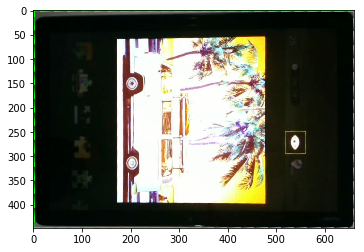

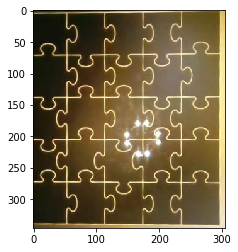

In [21]:
ply.initGame()

received: 
600 800 3
30000
1.9001007080078125
Template:  81.468 314.617 img shape:  (447, 662)


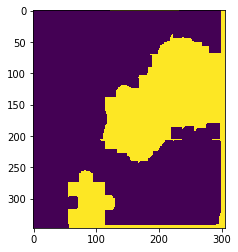

[[  0.           0.           4.72558803  61.43264433  60.03920171]
 [  0.           0.          63.12900927 245.73057733 255.        ]
 [  0.          29.01995723 255.         228.16108339 181.63221668]
 [  0.72701354  34.41197434  95.05702067  27.99002138  25.14255167]
 [ 16.72131148 222.22380613  21.68923735  10.78403421  35.50249465]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 3 3
received: 
600 800 3
30000
1.8778762817382812
###ROUND: None
received: 
(0.0, 265.0, 0)
received:     M         1         1 3 3         2 1 3
received:     M         4         0         0
received: 
(133.0, 213.0, 1)
received:   

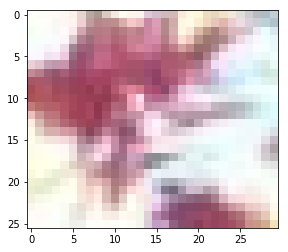

possible: [[ True  True  True  True  True]
 [ True  True  True False False]
 [ True  True False False False]
 [ True  True  True  True  True]
 [ True False  True  True  True]]
scores: [[0.46376997 0.47786045 0.46895629 0.50584352 0.31501901]
 [0.55868828 0.38244161 0.43194106 0.51984942 0.9321695 ]
 [0.45409229 0.47808668 0.41008419 0.48758665 0.48554263]
 [0.51933271 0.42749473 0.34156343 0.56966013 0.42797336]
 [0.42967889 0.38127658 0.12777771 0.45343444 0.26655868]]
DRAG TO:  4 1
received: 
(0.0, 0.0, 0)
received:     M         1         1 1 5         1 0 9
received:     M         4         0         0
received: 
(115.0, 109.0, 1)
received:     M         1         6 5         1 1 1
received:     M         3         0         0
received: 
(65.0, 111.0, 0)
received: 
(65.0, 111.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
1.9198150634765625
[[  0.           0.           8.54240912  61.73556664  71.91375624]
 [  0.       

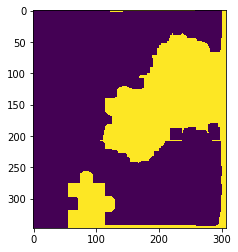

[[  0.           0.           8.66357805  73.79187455  72.15609408]
 [  0.           0.          54.04133999 242.27726301 255.        ]
 [  0.          23.68852459 251.42551675 225.9194583  188.05416964]
 [  0.36350677  32.71560941  98.63150392  31.56450463  24.96079829]
 [ 17.26657163 224.28367783  18.53884533   7.39130435  31.86742694]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 3 3
received: 
600 800 3
30000
1.9749298095703125
###ROUND: None
received: 
(0.0, 265.0, 0)
received:     M         1         1 3 5         2 1 5
received:     M         4         0         0
received: 
(135.0, 215.0, 1)
received:   

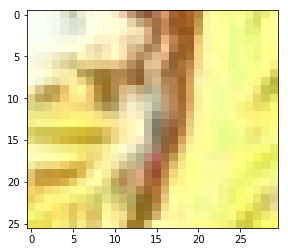

possible: [[ True  True  True  True  True]
 [ True  True  True False False]
 [ True  True False False False]
 [ True  True  True  True  True]
 [ True False  True  True  True]]
scores: [[0.48054641 0.29690498 0.36435184 0.28831398 0.34452555]
 [0.44079283 0.36142743 0.36434966 0.29581028 0.38597429]
 [0.37759423 0.39692298 0.21828981 0.31239218 0.3992222 ]
 [0.44707358 0.43917388 0.22781591 0.35043842 0.59680712]
 [0.29935443 0.3239736  0.12920481 0.35043707 0.89614141]]
DRAG TO:  4 4
received: 
(0.0, 0.0, 0)
received:     M         1         1 1 5         1 0 9
received:     M         4         0         0
received: 
(115.0, 109.0, 1)
received:     M         1         1 4 0         1 1 1
received:     M         3         0         0
received: 
(140.0, 111.0, 0)
received: 
(140.0, 111.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
1.9749298095703125
[[  0.           0.           8.30007128  59.13043478  73.42836778]
 [  0.   

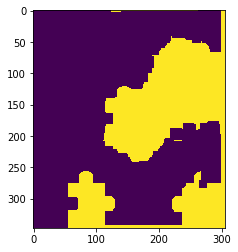

[[  0.           0.           8.17890235  55.07127584  64.64362081]
 [  0.           0.          45.49893086 236.03706344 255.        ]
 [  0.          21.9315752  248.6386315  221.19387028 166.1831789 ]
 [  0.36350677  29.38346401  93.84533143  29.50463293  35.68424804]
 [ 17.50890948 222.22380613  17.99358517  54.04133999 248.69921597]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 0 4
received: 
600 800 3
30000
1.909149169921875
###ROUND: (200, 350.728)
received: 
(0.0, 0.0, 0)
received:     M         1         1 3 4         2 1 5
received:     M         4         0         0
received: 
(134.0, 215.0, 1)
recei

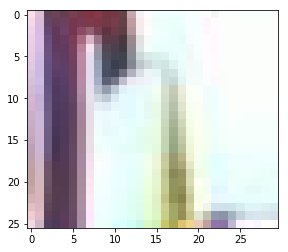

possible: [[ True  True  True  True  True]
 [ True  True  True False False]
 [ True  True False False False]
 [ True  True  True  True  True]
 [ True False  True  True False]]
scores: [[0.66774291 0.73834592 0.48043537 0.48753604 0.28767267]
 [0.71697235 0.55880225 0.61777127 0.33445129 0.40650463]
 [0.76382732 0.5441317  0.6076473  0.24641635 0.44622937]
 [0.72898513 0.60621423 0.67901093 0.48658481 0.58948225]
 [0.96558034 0.46085739 0.33135742 0.48872334 0.50697345]]
DRAG TO:  0 2
received: 
(0.0, 265.0, 0)
received:     M         1         1 4 0         1 7 6
received:     M         4         0         0
received: 
(140.0, 176.0, 1)
received:     M         1         9 0         2 0 2
received:     M         3         0         0
received: 
(90.0, 202.0, 0)
received: 
(90.0, 202.0, 0)
received:     M         1         0         2 6 5
received: 
600 800 3
30000
1.9614181518554688
[[  0.           0.           8.05773343  54.16250891  70.33856023]
 [  0. 

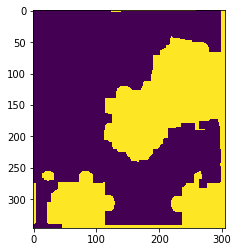

[[  0.           0.           8.11831789  53.55666429  71.36849608]
 [  0.           0.          48.64932288 235.6129722  255.        ]
 [  0.          26.5359943  250.75908767 212.83321454 163.09337135]
 [ 20.1746258   30.3528154   87.96863863  22.7191732   46.34711333]
 [148.5531005  235.6129722   23.93086244  63.43193158 249.1233072 ]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 1 0
received: 
600 800 3
30000
1.9480819702148438
###ROUND: None
received: 
(0.0, 265.0, 0)
received:     M         1         8 7         2 1 4
received:     M         4         0         0
received: 
(87.0, 214.0, 1)
received:     M

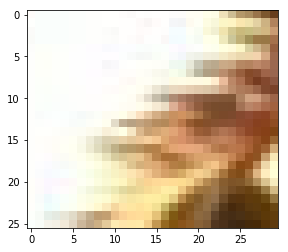

possible: [[ True  True  True  True  True]
 [ True  True  True False False]
 [ True  True False False False]
 [ True  True  True  True  True]
 [False False  True  True False]]
scores: [[0.67299849 0.70365566 0.75648129 0.51570314 0.64509511]
 [0.56052154 0.61268663 0.43735576 0.74043041 0.67952788]
 [0.60504514 0.77010429 0.4430103  0.70858568 0.73145795]
 [0.60504514 0.66148555 0.67417777 0.85247934 0.66836667]
 [0.68977141 0.43239146 0.47855538 0.85248017 0.66836667]]
DRAG TO:  3 4
received: 
(0.0, 265.0, 0)
received:     M         1         4 1         1 5 4
received:     M         4         0         0
received: 
(41.0, 154.0, 1)
received:     M         1         1 4 0         1 3 4
received:     M         3         0         0
received: 
(140.0, 134.0, 0)
received: 
(140.0, 134.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
1.9847030639648438
[[  0.           0.           9.81468282  40.8339273   58.9486814 ]
 [  0.    

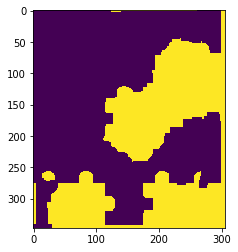

[[  0.           0.           7.9365645   46.16535994  60.40270848]
 [  0.           0.          38.47113329 226.58588738 255.        ]
 [  0.          21.50748396 247.48752673 212.22736992 126.43977192]
 [ 17.14540271  26.41482537  90.39201711  50.83036351  34.65431219]
 [151.70349252 234.21952958  37.80470421 241.9743407  248.03278689]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 0 0
received: 
600 800 3
30000
1.9414825439453125
###ROUND: (200, 349.728)
received: 
(0.0, 0.0, 0)
received:     M         1         1 3 4         2 1 4
received:     M         4         0         0
received: 
(134.0, 214.0, 1)
rece

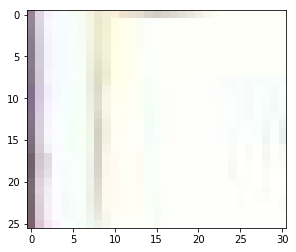

possible: [[ True  True  True  True  True]
 [ True  True  True False False]
 [ True  True False False False]
 [ True  True  True  True  True]
 [False False  True False False]]
scores: [[0.89292657 0.62263542 0.30071086 0.31760636 0.19604661]
 [0.91228497 0.50545061 0.6123215  0.21345429 0.17892528]
 [0.92402154 0.39513871 0.79692328 0.17511648 0.26848409]
 [0.91402042 0.4285022  0.92470497 0.2474295  0.26931599]
 [0.5912075  0.62903905 0.37908268 0.25294751 0.23394835]]
DRAG TO:  2 3
received: 
(0.0, 265.0, 0)
received:     M         1         4 1         1 7 6
received:     M         4         0         0
received: 
(41.0, 176.0, 1)
received:     M         1         1 1 5         1 5 7
received:     M         3         0         0
received: 
(115.0, 157.0, 0)
received: 
(115.0, 157.0, 0)
received:     M         1         0         2 6 5
received: 
600 800 3
30000
1.9978866577148438
[[  0.           0.           7.69422666  43.80256593  68.46044191]
 [  0.

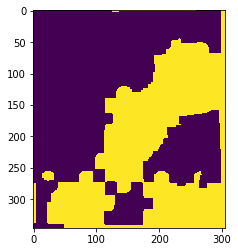

[[  0.           0.           7.75481112  38.59230221  64.46186743]
 [  0.           0.          39.86457591 227.00997862 255.        ]
 [  0.          25.86956522 249.42622951 199.50463293 114.01995723]
 [ 19.93228795  87.12045617 231.85673557  53.0719886   44.77191732]
 [147.46258019 234.3406985   67.18816821 243.73129009 249.48681397]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 3 3
received: 
600 800 3
30000
1.909149169921875
###ROUND: None
received: 
(0.0, 265.0, 0)
received:     M         1         1 1 1         2 1 4
received:     M         4         0         0
received: 
(111.0, 214.0, 1)
received:    

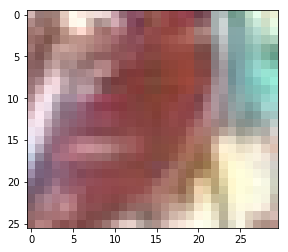

possible: [[ True  True  True  True  True]
 [ True  True  True False False]
 [ True  True False False False]
 [ True  True False  True  True]
 [False False  True False False]]
scores: [[0.60801297 0.42626154 0.44859836 0.40639663 0.37830356]
 [0.74792075 0.32925335 0.36961818 0.45594153 0.49738201]
 [0.57101601 0.63261694 0.33992791 0.36625418 0.71499038]
 [0.63519233 0.48394817 0.17753592 0.54633653 0.98044956]
 [0.52678502 0.34325919 0.22885446 0.47229281 0.3376072 ]]
DRAG TO:  4 3
received: 
(0.0, 0.0, 0)
received:     M         1         1 1 5         1 0 9
received:     M         4         0         0
received: 
(115.0, 109.0, 1)
received:     M         1         1 1 5         1 1 1
received:     M         3         0         0
received: 
(115.0, 111.0, 0)
received: 
(115.0, 111.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
1.8986053466796875
[[  0.           0.           7.6336422   43.31789024  65.18888097]
 [  0.   

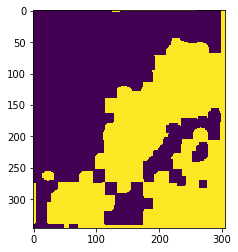

[[  0.           0.           7.81539558  42.95438346  66.21881682]
 [  0.           0.          46.04419102 227.25231646 255.        ]
 [  0.          27.20242338 248.6386315  199.38346401 149.8253742 ]
 [ 19.99287242  87.78688525 232.34141126 104.02352103 210.71275837]
 [146.06913756 230.34212402  67.18816821 243.73129009 249.48681397]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 0 3
received: 
600 800 3
30000
1.8840484619140625
###ROUND: (200, 352.506)
received: 
(0.0, 0.0, 0)
received:     M         1         1 3 6         2 1 5
received:     M         4         0         0
received: 
(136.0, 215.0, 1)
rece

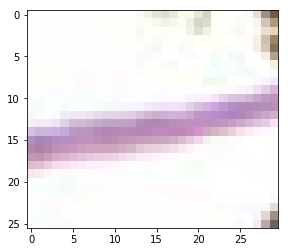

possible: [[ True  True  True  True  True]
 [ True  True  True False False]
 [ True  True False False False]
 [ True  True False False False]
 [False False  True False False]]
scores: [[0.41778487 0.76598525 0.79045671 0.43142122 0.35024425]
 [0.43379024 0.66203868 0.8697297  0.61505151 0.47720331]
 [0.33457831 0.28651398 0.54179156 0.53480649 0.34849817]
 [0.30782154 0.35684049 0.54179156 0.46832821 0.30914411]
 [0.32372943 0.2367741  0.34246573 0.29690173 0.29236853]]
DRAG TO:  2 1
received: 
(0.0, 265.0, 0)
received:     M         1         1 1 5         1 7 7
received:     M         4         0         0
received: 
(115.0, 177.0, 1)
received:     M         1         6 5         1 5 6
received:     M         3         0         0
received: 
(65.0, 156.0, 0)
received: 
(65.0, 156.0, 0)
received:     M         1         0         2 6 5
received: 
600 800 3
30000
1.9749298095703125
[[  0.           0.           7.1489665   24.17320029  51.98146828]
 [  0. 

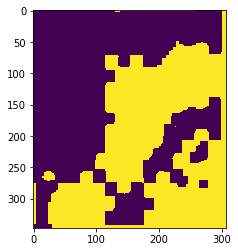

[[  0.           0.           6.90662865  25.68781183  53.67783321]
 [  0.          19.44761226 205.01781896 223.25374198 253.84889522]
 [  0.          21.14397719 246.5787598  172.42337847  87.60513186]
 [ 16.17605132  76.63934426 234.3406985   94.02708482 203.2002851 ]
 [151.40057021 234.21952958  58.88809694 240.27797577 248.09337135]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 1 0
received: 
600 800 3
30000
1.9198150634765625
###ROUND: None
received: 
(0.0, 265.0, 0)
received:     M         1         1 3 4         2 1 5
received:     M         4         0         0
received: 
(134.0, 215.0, 1)
received:   

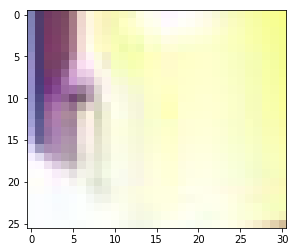

possible: [[ True  True  True  True  True]
 [ True  True False False False]
 [ True  True False False  True]
 [ True  True False  True False]
 [False False  True False False]]
scores: [[0.60574555 0.98947012 0.6428405  0.62891001 0.44062787]
 [0.78881443 0.55279827 0.50207186 0.51462758 0.47092536]
 [0.64123905 0.48545244 0.57115829 0.25695094 0.37663245]
 [0.79967797 0.56802976 0.64749086 0.5613941  0.48899505]
 [0.75203454 0.45718834 0.5279718  0.5354144  0.48105517]]
DRAG TO:  0 3
received: 
(0.0, 265.0, 0)
received:     M         1         4 1         1 5 4
received:     M         4         0         0
received: 
(41.0, 154.0, 1)
received:     M         1         1 1 5         2 0 2
received:     M         3         0         0
received: 
(115.0, 202.0, 0)
received: 
(115.0, 202.0, 0)
received:     M         1         0         2 6 5
received: 
600 800 3
30000
1.9305877685546875
[[ 14.05559515 181.93513899  17.87241625  24.83962937  52.82965075]
 [  0.

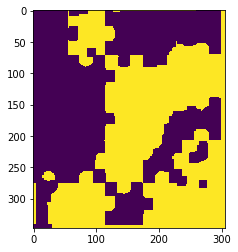

[[ 14.11617962 197.86885246  17.81183179  23.74910905  52.89023521]
 [  0.72701354  43.31789024 205.01781896 216.77120456 253.84889522]
 [  0.          21.20456165 246.63934426 164.9109052   87.84746971]
 [ 16.17605132  75.97291518 234.15894512  91.42195296 204.59372773]
 [150.97647897 234.15894512  58.88809694 241.06557377 248.57804704]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 0 2
received: 
600 800 3
30000
1.9480819702148438
###ROUND: (200, 349.728)
received: 
(0.0, 265.0, 0)
received:     M         1         1 3 4         2 1 6
received:     M         4         0         0
received: 
(134.0, 216.0, 1)
re

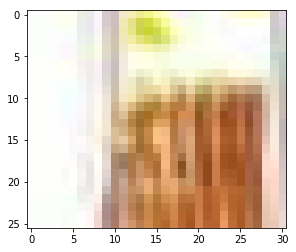

possible: [[ True False  True  True  True]
 [ True  True False False False]
 [ True  True False False  True]
 [ True  True False  True False]
 [False False  True False False]]
scores: [[0.46113282 0.66719717 0.72403282 0.45623252 0.53843361]
 [0.51884753 0.73227364 0.30862254 0.58783025 0.62301731]
 [0.34408647 0.97139591 0.36116341 0.65208936 0.61767405]
 [0.58744144 0.58733779 0.50300151 0.69604206 0.52074599]
 [0.76339412 0.46883941 0.47312328 0.637119   0.52524465]]
DRAG TO:  1 2
received: 
(0.0, 265.0, 0)
received:     M         1         9 1         1 7 6
received:     M         4         0         0
received: 
(91.0, 176.0, 1)
received:     M         1         9 0         1 7 9
received:     M         3         0         0
received: 
(90.0, 179.0, 0)
received: 
(90.0, 179.0, 0)
received:     M         1         0         2 6 5
received: 
600 800 3
30000
2.04541015625
[[ 11.63221668 187.93300071  20.11404134  14.17676408  51.13328582]
 [  1.09052031 

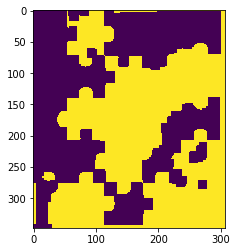

[[ 11.63221668 188.05416964  20.71988596  14.41910192  51.01211689]
 [  1.09052031  62.94725588 200.71632217 207.38061297 252.63720599]
 [ 45.07483963 229.13043478 255.         159.27655025  82.21311475]
 [ 14.41910192  75.06414825 234.64362081  89.72558803 201.07982894]
 [150.18888097 233.73485388  56.76764077 237.55167498 247.12401996]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 2 0
received: 
600 800 3
30000
1.9749298095703125
###ROUND: None
received: 
(0.0, 265.0, 0)
received:     M         1         1 3 5         2 1 5
received:     M         4         0         0
received: 
(135.0, 215.0, 1)
received:   

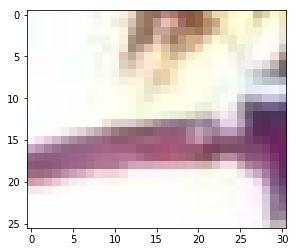

possible: [[ True False  True  True  True]
 [ True  True False False False]
 [ True False False False  True]
 [ True  True False  True False]
 [False False  True False False]]
scores: [[0.40104952 0.55339724 0.98383105 0.43035835 0.39132446]
 [0.37929803 0.61296815 0.69691151 0.60418051 0.48662001]
 [0.38231641 0.33518502 0.46478173 0.56647974 0.36913171]
 [0.38930923 0.3736321  0.49426642 0.57922584 0.32046697]
 [0.31194809 0.29827246 0.35602924 0.38710412 0.30687633]]
DRAG TO:  2 1
DRAG TO:  1 1
received: 
(0.0, 265.0, 0)
received:     M         1         4 1         1 3 1
received:     M         4         0         0
received: 
(41.0, 131.0, 1)
received:     M         1         6 5         1 7 9
received:     M         3         0         0
received: 
(65.0, 179.0, 0)
received: 
(65.0, 179.0, 0)
received:     M         1         0         2 6 5
received: 
600 800 3
30000
2.4366531372070312
[[ 12.11689237 221.3150392  207.80470421  15.99429793  52.344975

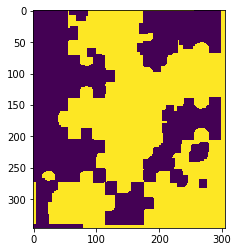

[[ 13.87384177 212.04561654 211.50035638  20.47754811  53.92017106]
 [  0.60584462  63.97719173 234.03777619 208.65288667 255.        ]
 [ 42.28795438 229.31218817 255.         127.16678546  80.88025659]
 [ 19.93228795  78.39629366 230.52387741  93.54240912 196.59657876]
 [142.07056308 230.70563079  64.40128297 240.27797577 249.48681397]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 4 0
received: 
600 800 3
30000
6.241912841796875
###ROUND: None
received: 
(0.0, 265.0, 0)
received:     M         1         4 0         2 1 6
received:     M         4         0         0
received: 
(40.0, 216.0, 1)
received:     M 

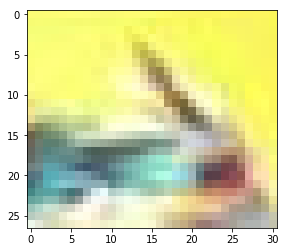

possible: [[ True False False  True  True]
 [ True  True False False False]
 [ True False False False  True]
 [ True  True False  True False]
 [False False  True False False]]
scores: [[0.2975961  0.26870307 0.27958873 0.5757401  0.95856482]
 [0.28407976 0.27326038 0.36598185 0.37630484 0.2831485 ]
 [0.43606499 0.20716876 0.39765584 0.41326347 0.26619586]
 [0.32255605 0.22269726 0.29373237 0.30195332 0.16048677]
 [0.30548921 0.36283314 0.3066327  0.51817387 0.5318113 ]]
DRAG TO:  3 0
received: 
(0.0, 0.0, 0)
received:     M         1         4 1         8 6
received:     M         4         0         0
received: 
(41.0, 86.0, 1)
received:     M         1         4 1         1 3 4
received:     M         3         0         0
received: 
(41.0, 134.0, 0)
received: 
(41.0, 134.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
6.1008453369140625
[[  0.         162.97390903 245.16739783 113.86977603 239.63287924]
 [  0.          57.

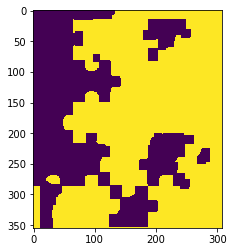

[[  0.         162.97390903 244.81413069 110.04271531 239.63287924]
 [  0.          56.75825444 220.20318633 243.34218425 255.        ]
 [ 15.77926576 214.37427846 253.11590857 218.79011776 243.57769568]
 [ 16.30916647  47.80882013 236.68898638  45.57146156 208.2509813 ]
 [145.89933041 250.40752713  64.76564304 215.19856846 250.40752713]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 0 1
received: 
600 800 3
30000
6.064109802246094
###ROUND: (201, 358.949)
received: 
(0.0, 0.0, 0)
received:     M         1         1 3 4         2 1 4
received:     M         4         0         0
received: 
(134.0, 214.0, 1)
recei

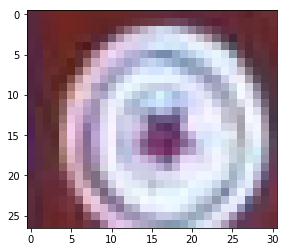

possible: [[ True False False False False]
 [ True  True False False False]
 [ True False False False False]
 [ True  True False  True False]
 [False False  True False False]]
scores: [[0.57948965 0.66390067 0.47477642 0.46449393 0.3773098 ]
 [0.96345347 0.43186501 0.5192619  0.45305148 0.49367967]
 [0.52440423 0.55954534 0.49928233 0.37798724 0.43874276]
 [0.8603152  0.47027543 0.45427096 0.49345025 0.55423045]
 [0.58293396 0.44867134 0.30081934 0.42797533 0.42018497]]
DRAG TO:  0 3
received: 
(0.0, 265.0, 0)
received:     M         1         6 6         1 7 7
received:     M         4         0         0
received: 
(66.0, 177.0, 1)
received:     M         1         1 1 5         2 0 2
received:     M         3         0         0
received: 
(115.0, 202.0, 0)
received: 
(115.0, 202.0, 0)
received:     M         1         0         2 6 5
received: 
600 800 3
30000
6.5745697021484375
[[  5.12237359 174.0429462  247.52251212 128.82475179 253.94019857]
 [133.

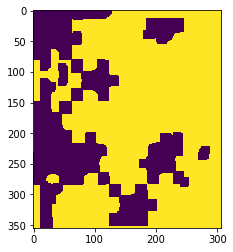

[[  5.00461787 174.10182406 248.40567998 133.00507966 253.64580928]
 [134.94804895  96.32417456 231.97875779 255.         255.        ]
 [ 52.04802586 219.43777419 254.29346571 226.56199492 255.        ]
 [ 17.72223505  53.22558301 240.28053567  56.11059801 223.44146848]
 [151.37497114 253.05703071  64.88339875 224.7956592  252.93927499]]
[[0.00000000e+00 1.81753386e-01 8.54240912e+00 1.05780470e+02
  8.79686386e+01]
 [0.00000000e+00 0.00000000e+00 3.95616536e+01 2.51789024e+02
  2.55000000e+02]
 [0.00000000e+00 1.44796864e+01 2.34583036e+02 2.55000000e+02
  2.30887384e+02]
 [0.00000000e+00 7.20955096e+00 9.17854597e+01 2.76870991e+01
  3.42302210e+01]
 [2.42337847e-01 1.47826087e+01 1.43585175e+01 1.12081254e+01
  5.44654312e+01]]
###EX,EY#### 0 0
received: 
600 800 3
30000
6.599922180175781
###ROUND: (201, 366.949)
received: 
(0.0, 265.0, 0)
received:     M         1         1 4 0         2 1 4
received:     M         4         0         0
received: 
(140.0, 214.0, 1)
rec

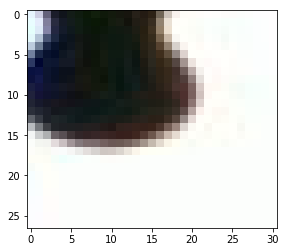

possible: [[ True False False False False]
 [False  True False False False]
 [ True False False False False]
 [ True  True False  True False]
 [False False  True False False]]
scores: [[0.69567043 0.76699632 0.65507466 0.68499696 0.2735979 ]
 [0.78917187 0.48571819 0.57139033 0.54790694 0.57642722]
 [0.5514878  0.74050003 0.54298675 0.32499212 0.41784224]
 [0.78405941 0.65762806 0.41028845 0.72157139 0.67196405]
 [0.64685583 0.39308473 0.28667614 0.58432859 0.34775621]]
DRAG TO:  0 1
DRAG TO:  0 3
received: 
(0.0, 265.0, 0)
received:     M         1         4 1         1 7 7
received:     M         4         0         0
received: 
(41.0, 177.0, 1)
received:     M         1         1 1 5         2 0 2
received:     M         3         0         0
received: 
(115.0, 202.0, 0)
received: 
(115.0, 202.0, 0)
received:     M         1         0         2 6 5
received: 
600 800 3
30000
6.299354553222656
[[ 11.32929437 209.25873129 252.27369922 104.81111903 241.368

KeyboardInterrupt: 

In [23]:
for i in range(25):
    ply.playOneStep()

In [35]:
#ply.tryOneDrag(100,40, 300,100,ply.sourceimg.shape[:2])
ply.tryOneDrag(430,440, 420,200,ply.sourceimg.shape[:2])
#cli.takAction(1,45,10)

AttributeError: 'NoneType' object has no attribute 'shape'

In [74]:
img = ply.getOneShot() # whole screen before move
target = cutout_target(img)
a= ply.DragToCorner(target.shape[:2],img.shape[:2],None,4,4)

received: 
600 800 3
30000
-0.0
received: 
600 800 3
30000
-0.0
###ROUND: None
received: 
(0.0, 265.0, 0)
received:     M         1         8 0         2 1 5
received:     M         4         0         0
received: 
(80.0, 215.0, 1)
received:     M         1         1 4 0         1 1 1
received:     M         3         0         0
received: 
(140.0, 111.0, 0)
received: 
(140.0, 111.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-0.0


In [ ]:
ply.sourceimg.shape[:2]

received:     M         1         3 5         0


In [47]:
from matchUtil import *

In [45]:
# ply.movetoImg(82.878+20,203.391+30,(481,727)) # the +20 and +30 here is to assemble the effect in tryOneDrag
ply.movetoImg(150,85,(481,727)) # the +20 and +30 here is to assemble the effect in tryOneDrag

received: 
(35.0, 196.0, 1)
received:     M         1         3 6         1 9 6


In [21]:
cli.takAction(3,0,0)

received:     M         3         0         0


In [37]:
ply.retreat()

received: 
(10.0, 255.0, 0)
received:     M         1         0         0


In [16]:
def DragToCorner(ply,sor_shape,img_shape,tempPos = None,ex = 0, ey = 0):
    img = ply.getOneShot()
    target = cutout_target(img)
    if(tempPos is None):
        tempPos = []
        _ = cutout_template(None,img.copy(),tempPos)
        x0,y0 = (tempPos[0] + img.shape[1]*0.114 , tempPos[1] + img.shape[0]*0.111)
    else:
        x0,y0 = tempPos
#     (x0,y0), _= matching(ply.sourceimg,img.copy(),mode = "match",debug = True)
    # shift from the corner to the middle of the template
    x0,y0 = x0+10+20, y0+30
    
#     x,y = int(img.shape[1]*0.273), int(img.shape[0]*0.120)
    x = int(ex*sor_shape[1]/5) + int(img_shape[1]*0.273)
    y = int(ey*sor_shape[0]/5) + int(img_shape[0]*0.120)
    print("###########################")
    print("DRAG TO CORNER tryOneDrag:",x0,y0,x,y,img.shape[:2])
    return ply.tryOneDrag(x0,y0,x,y,img.shape[:2],shot = True,back = False,roundAbout = (x+20,y0))
# img = DragToCorner(ply)

In [42]:
# ply.movetoImg(180+20,57+40, [479,730])
# cli.takAction(4,0,0)
ply.movetoImg(199,57, [479,730])

# ply.retreat()

received: 
(41.0, 204.0, 1)
received:     M         1         4 3         2 0 4


In [17]:
def dragToGrid(ply,x0,y0,x1,y1,sor_shape,img_shape,shot,back = True):
    """
    x,y is the cordinate of the source area 0...4
    """
    x0 = int(x0*sor_shape[1]/5 + img_shape[1]*0.273 + sor_shape[1]/10)
    y0 = int(y0*sor_shape[0]/5 + img_shape[0]*0.120 + sor_shape[0]/10)
    x1 = int(x1*sor_shape[1]/5) + int(img_shape[1]*0.273)
    y1 = int(y1*sor_shape[0]/5) + int(img_shape[0]*0.120)
    # to get to the middle of the template
#     x0,y0 = x0 +34, y0+37 # sor_shape[1]/10
    
    print("ply.tryOneDrag",x0,y0,x1,y1,img_shape[:2],shot,back)
    return ply.tryOneDrag(x0,y0,x1,y1,img_shape[:2],shot = shot,back = back)

# img = ply.getOneShot()
# sor = cutout_target(img)
# plt.imshow(sor)
# plt.show()
# dragToGrid(ply,2,2,0,0,sor.shape[:2],img.shape[:2],False)
# dragToGrid(ply,0,0,2,4,sor.shape[:2],img.shape[:2],False)

In [117]:
sor.shape

(373, 337, 3)

In [119]:
ply.movetoImg(233-34-35,94-37+37, [481,729])

received: 
(41.0, 206.0, 1)
received:     M         1         4 1         1 9 9


In [14]:
ply.retreat()

received: 
(115.0, 201.0, 0)
received:     M         1         0         0


In [46]:
cli.takAction(3,0,0)

received:     M         3         0         0


received: 
600 800 3
30000
-4.618321895599365


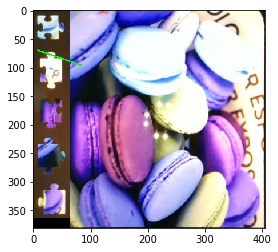

Template:  92.24600000000001 124.501 img shape:  (491, 739)


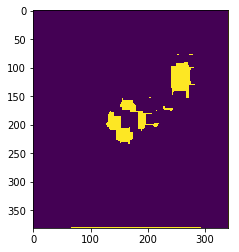

[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         78.45394737  6.51315789]
 [ 0.          8.63486842 95.03289474  7.45065789  0.        ]
 [ 0.          0.          3.40460526  0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
###EX,EY#### 0 1
received: 
600 800 3
30000
-4.642602443695068
###########################
DRAG TO CORNER tryOneDrag: 122.24600000000001 154.501 201 134 (490, 739)
received: 
(0.0, 0.0, 0)
received:     M         1         6 0         2 1 4
received:     M         4         0         0
received: 
(60.0, 214.0, 1)
received:     M         1         6 0         1 8 1
received: 
(60.0, 181.0, 1)
received:     M         1         6 5         2 0 2
received:     M         3         0         0
received: 
(65.0, 202.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.631568908691406


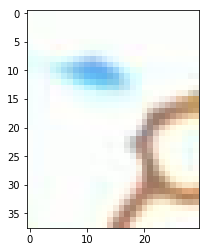

possible: [[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
scores: [[0.39137036 0.35084978 0.43317109 0.35996634 0.32592461]
 [0.36647126 0.37512842 0.21797448 0.38057801 0.95553893]
 [0.35133514 0.33200192 0.3967047  0.41774747 0.36669064]
 [0.38163379 0.32586282 0.48349586 0.45936084 0.30181432]
 [0.27295566 0.32783064 0.41211614 0.46671093 0.34858206]]
DRAG TO:  4 1
ply.tryOneDrag 235 173 474 134 (491, 739) True False
received: 
(0.0, 0.0, 0)
received:     M         1         6 6         1 7 7
received:     M         4         0         0
received: 
(66.0, 177.0, 1)
received:     M         1         6 6         1 1 1
received:     M         3         0         0
received: 
(66.0, 111.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.669733047485352


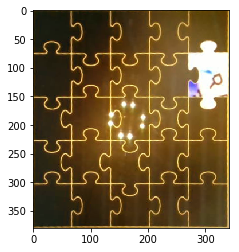

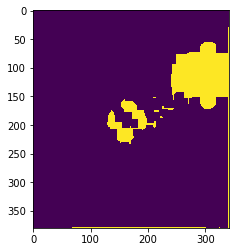

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.97368421e-01
  2.95065789e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.82401316e+01
  2.54062500e+02]
 [0.00000000e+00 6.85855263e+00 1.02927632e+02 1.06085526e+01
  2.50164474e+01]
 [0.00000000e+00 0.00000000e+00 2.66447368e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 3.35526316e+00 3.35526316e+00 3.35526316e+00
  1.52960526e+00]]
TRIED: 1
DRAG TO:  2 3
ply.tryOneDrag 509 173 337 286 (491, 739) True False
received: 
(0.0, 0.0, 0)
received:     M         1         6 6         8 6
received:     M         4         0         0
received: 
(66.0, 86.0, 1)
received:     M         1         1 1 5         1 5 7
received:     M         3         0         0
received: 
(115.0, 157.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.621251583099365


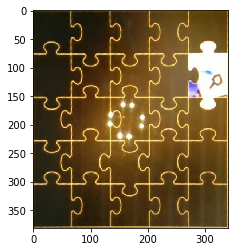

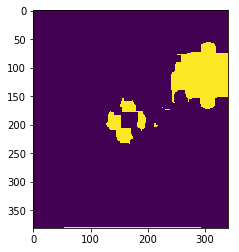

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 4.93421053e-02
  2.53125000e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.71875000e+01
  2.55000000e+02]
 [0.00000000e+00 8.78289474e+00 9.44901316e+01 5.62500000e+00
  2.66447368e+01]
 [0.00000000e+00 0.00000000e+00 4.34210526e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]
TRIED: 2


In [19]:
def playOneStep(ply):
    img = ply.getOneShot() # whole screen before move
    target = cutout_target(img.copy())
    
    (x0,y0), scores = old_matching(ply.sourceimg.copy(),img.copy(),mode = "match",debug = True)
    print("Template: ",x0,y0,"img shape: ", img.shape[:2])
    #应该还需要10-20的调整
    #为什么有时候会出现不停止直接走然后图像出现异常的情况
    possible = findEmpty(ply.emptyimg,target,mode = "debug")
    ey = np.argmax(scores)//5 
    ex = np.argmax(scores)%5
    while(not possible[ey][ex]):
        scores[ey][ex] = -1
        ey = np.argmax(scores)//5 
        ex = np.argmax(scores)%5
    print("###EX,EY####",ex,ey)
    moved_template = DragToCorner(ply,target.shape[:2],img.shape[:2],(x0,y0),ex,ey) # screen after the template is moved to corner
#     global tmpcount
#     cv2.imwrite("tmpMovedTemplate%d.png"%tmpcount,moved_template)
#     cv2.imwrite("tmpSourceImg%d.png"%tmpcount,img)
#     tmpcount += 1    
    template = find_template(moved_template,img,ex,ey)
    plt.imshow(template)
    plt.show()
    source = cutout_target(ply.sourceimg)
    scores = matching(source,template)
#     print("Rx,RY",rx,ry)
#     rx,ry = min(4,rx),min(4,ry)
#     rx,ry = int(rx),int(ry)
#     scores = matching(ply.sourceimg,moved_template,img,mode = "match",debug = True)
#     scores[ry][rx] = 99999999
    initial_num = possible.sum()
    print("possible:", possible)
    print("scores:",scores)
#     ex,ey = 0,0 # the point to check the correctness
    scores[ey][ex] = -1
    triedCount = 0
    while(possible.sum()>0):
        y = np.argmax(scores)//5 # x => i 
        x = np.argmax(scores)%5
        print("DRAG TO: ",x,y)
        scores[y][x]=-1
        if(not possible[y][x] ): # we don't have to move to 0,0, we just check it in the next round
            continue
        possible[y][x] = False
        
        timg = dragToGrid(ply,ex,ey,x,y,target.shape[:2],img.shape[:2],shot=True, back = False)
        timg = cutout_target(timg)
#         print("Tries To Drag:",x0,y0,x,y)
        
        triedCount += 1
        
        plt.imshow(timg)
        plt.show()
        empty = findEmpty(ply.emptyimg,timg,mode = "debug")
        print("TRIED:", triedCount )
        if(not empty[ey][ex] or empty[y][x]):
            break
        ex,ey = x,y
playOneStep(ply)

In [15]:
tmpcount = 0

In [108]:
img = ply.getOneShot()
cv2.imwrite("tmp.png",img)



received: 
600 800 3
30000
-1.9349322319030762


True

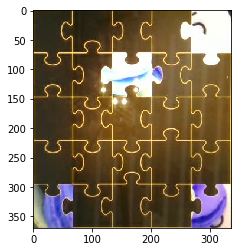

(370, 337, 3)


In [92]:
# ply.movetoImg(197,54,img.shape[:2])
# ply.movetoImg(532,427,img.shape[:2])
sor = cutout_target(img)

plt.imshow(sor)
plt.show()
print(sor.shape)